# Area sampling using Dask and Xarray
Computational improvement based on test_area_sample_PETandLtheta.ipynb

In [1]:
from dask.distributed import Client
import xarray as xr
import numpy as np
import bottleneck
from datetime import datetime
import os
import rasterio as rio
import functools
import glob
import warnings
warnings.filterwarnings("ignore")

In [264]:
###### Define constants ###########
network_name = "California"
minx = -124.5
miny = 32.5
maxx = -114
maxy = 42.5
bbox = {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

# Changable
chunks = {'x': 100, 'y': 100}
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002
startDate = datetime(2016, 1, 1)
endDate = datetime(2017, 1, 1)


# Non-changable
SMAPL4_times = ['0130', '0430', '0730', '1030', '1330', '1630', '1930', '2230'] # 3-hourly data

###### PATH ###########
input_path = r"..\1_data"
output_path = r"..\3_data_out"
SMAPL3_path = "SPL3SMP_E"
SMAPL4_path = "SPL4SMGP"
SMAPL4_grid_path = "SMAPL4SMGP_EASEreference"
PET_path = "PET"

In [3]:
client = Client(n_workers=10, threads_per_worker=5, memory_limit='16GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 50,Total memory: 149.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61456,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 50
Started: Just now,Total memory: 149.01 GiB
Comm: tcp://127.0.0.1:61520,Total threads: 5
Dashboard: http://127.0.0.1:61523/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:61459,


## Read data 

### Read SMAP L4 data

In [4]:
def _preprocess_SMAPL4(ds):
    # Assign missing time dimension
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    endTime = datetime.strptime(ds.rangeEndingDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    midTime = startTime + (startTime - endTime)/2
    ds = ds.assign_coords(time=midTime)
    # ds = ds.isel(y=slice(None, None, -1))
    # ds = ds.reindex(y=ds.y*(-1))
    return ds

# https://stackoverflow.com/questions/65376109/use-xarray-open-mfdataset-on-files-with-no-time-dimension-included

In [5]:
# Get a list of files 
# Test with 2016 Jan 1-9 data first
SMAPL4_fn_pattern = f'SMAP_L4_SM_gph_{startDate.year}010*.nc'
SMAPL4_file_paths = glob.glob(rf'{input_path}/{SMAPL4_path}/{SMAPL4_fn_pattern}')

# Load data
ds_SMAPL4 = xr.open_mfdataset(SMAPL4_file_paths, engine="rasterio", preprocess=_preprocess_SMAPL4, chunks=chunks, combine='nested', concat_dim='time', parallel=True)

# TODO/ISSUE #1: I need to use engine="rasterio" which takes x5 times than engine="netcdf4"
# Otherwise, precipitation variable is not read. 
# This is probably because precipitation variable is stored one level below of all other variables (lat, lon, etc.)
# 40sec to read 1 mo of data 

# TODO/ISSUE #2: For both L3 and L4 data, Y axis is read upside down, so I need to reset the index 
# Debug attempt: 
# ds_SMAPL4 = ds_SMAPL4.reindex(y=ds_SMAPL4.y*(-1))
# The chunking over the y axis disappers. Plus, numeric values within precipitation data disappears
# Debug attempt2: 
# ds_SMAPL4_P = ds_SMAPL4_P.isel(y=slice(None, -1))
# This just select the values and does not change the dimension values
# Debug attempt3: 
# ds_SMAPL4_P = ds_SMAPL4_P.reindex_like(SMAPL4)
# Numeric values within precipitation data disappears

# TODO #3: open_mfdataset(parallel=True) is not really making things super fast. Need to otimize

# # https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset

<xarray.Dataset>
Dimensions:                           (band: 1, x: 3856, y: 1822, time: 72)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -180.0 -179.9 ... 179.9 180.0
  * y                                 (y) float64 -85.01 -84.92 ... 84.9 85.0
    projection_information            int32 0
  * time                              (time) datetime64[ns] 2015-12-31T22:30:...
Data variables:
    cell_column                       (time, band, y, x) float64 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
    cell_lat                          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
    cell_lon                          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
    cell_row                          (time, band, y, x) float64 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
    precipitation_total_surface_flux  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            JPL CL#14-2285, JPL 400-1567
    publicationDate:                    2014-07-01
    title:                              SMAP Handbook
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

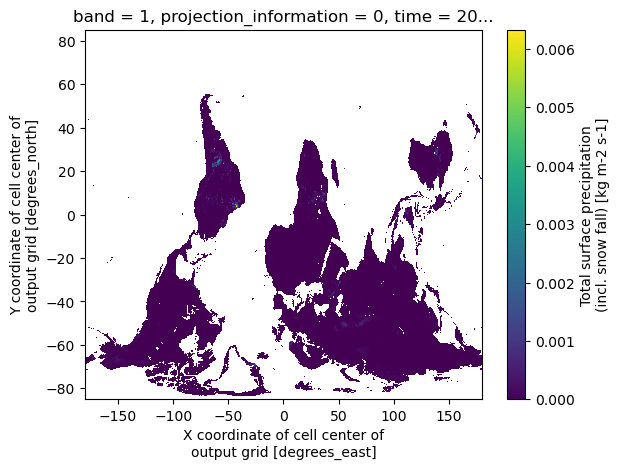

In [8]:
ds_SMAPL4_P = ds_SMAPL4.precipitation_total_surface_flux.copy()
ds_SMAPL4_P = ds_SMAPL4_P.isel(y=slice(None, None, -1))

ds_SMAPL4 = ds_SMAPL4.isel(y=slice(None, None, -1))
ds_SMAPL4.precipitation_total_surface_flux.sel(time='2016-01-01 01:30:00').plot()
ds_SMAPL4

<xarray.Dataset>
Dimensions:                           (band: 1, x: 113, y: 107, time: 72)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -124.5 -124.4 ... -114.0
  * y                                 (y) float64 -42.44 -42.35 ... -32.54
    projection_information            int32 0
  * time                              (time) datetime64[ns] 2015-12-31T22:30:...
Data variables:
    cell_column                       (time, band, y, x) float64 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
    cell_lat                          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
    cell_lon                          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
    cell_row                          (time, band, y, x) float64 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
    precipitation_total_surface_flux  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            JPL CL#14-2285, JPL 400-1567
    publicationDate:                    2014-07-01
    title:                              SMAP Handbook
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

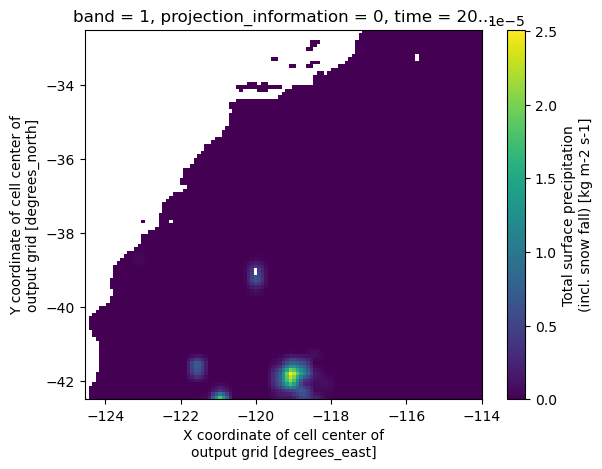

In [10]:
ds_SMAPL4_clipped = ds_SMAPL4.sel(x=slice(minx, maxx), y=slice(maxy*(-1), miny*(-1)))
ds_SMAPL4_clipped.sel(time='2016-01-01 01:30:00').precipitation_total_surface_flux.plot()
ds_SMAPL4_P_clipped = ds_SMAPL4_P.sel(x=slice(minx, maxx), y=slice(maxy*(-1), miny*(-1))).copy()
ds_SMAPL4_clipped
# ds_SMAPL4_P_clipped.sel(time='2016-01-01 01:30:00').plot()
# ds_SMAPL4_P_clipped
# ds_SMAPL4_P_clipped = ds_SMAPL4_P.sel(x=slice(minx, maxx), y=slice(miny, maxy))
# ds_SMAPL4_P_clipped.sel(time='2016-01-01 01:30:00').plot()
# ds_SMAPL4_P.rio.write_crs('epsg:4326', inplace=True)

### Read SMAP L3 data

In [9]:
def _preprocess_SMAPL3(ds):
    # Assign missing time dimension
    # Doesn't care about time as it is daily data
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split("T")[0], '%Y-%m-%d')
    ds = ds.assign_coords(time=startTime)
    return ds

In [11]:
# Get a list of files 
# Test with 2016 Jan 1-9 data first
SMAPL3_fn_pattern = f'SMAP_L3_SM_P_E_{startDate.year}010*.nc'
SMAPL3_file_paths = glob.glob(rf'{input_path}/{SMAPL3_path}/{SMAPL3_fn_pattern}')
# Load data
ds_SMAPL3 = xr.open_mfdataset(SMAPL3_file_paths, preprocess=_preprocess_SMAPL3, engine="rasterio", chunks=chunks, combine="nested", concat_dim="time")
# ds_SMAPL3 # = ds_SMAPL3.isel(y=slice(None, None, -1))


<xarray.Dataset>
Dimensions:                 (band: 1, x: 3856, y: 1822, time: 9)
Coordinates:
  * band                    (band) int32 1
  * x                       (x) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * y                       (y) float64 85.0 84.9 84.81 ... -84.83 -84.92 -85.01
    /crs                    int32 0
  * time                    (time) datetime64[ns] 2016-01-01 ... 2016-01-09
Data variables:
    EASE_column_index       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    longitude_pm            (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    retrieval_qual_flag_pm  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    soil_moisture_pm        (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    EASE_row_index          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    latitude                (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    longitude               (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    retrieval_qual_flag     (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    soil_moisture           (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    EASE_column_index_pm    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    EASE_row_index_pm       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    latitude_pm             (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
Attributes: (12/82)
    antennaRotationRate:                  14.6
    description:                          A configuration file generated auto...
    identifier:                           L3_SM_P_E_SPS
    edition:                              1.0
    publicationDate:                      2013-02-08
    title:                                Product Specification Document for ...
    ...                                   ...
    identifier_product_DOI:               doi:10.5067/4DQ54OUIJ9DL
    longName:                             SMAP Enhanced L3 Radiometer Global ...
    mission:                              SMAP
    pointOfContact:                       National Snow and Ice Data Center
    resourceProviderOrganizationName:     National Aeronautics and Space Admi...
    revisionDate:                         2021-08-31

<xarray.Dataset>
Dimensions:                 (band: 1, x: 113, y: 107, time: 9)
Coordinates:
  * band                    (band) int32 1
  * x                       (x) float64 -124.5 -124.4 -124.3 ... -114.1 -114.0
  * y                       (y) float64 42.43 42.33 42.24 ... 32.72 32.62 32.53
    /crs                    int32 0
  * time                    (time) datetime64[ns] 2016-01-01 ... 2016-01-09
Data variables:
    EASE_column_index       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    longitude_pm            (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    retrieval_qual_flag_pm  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture_pm        (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_row_index          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    latitude                (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    longitude               (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    retrieval_qual_flag     (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture           (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_column_index_pm    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_row_index_pm       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    latitude_pm             (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
Attributes: (12/82)
    antennaRotationRate:                  14.6
    description:                          A configuration file generated auto...
    identifier:                           L3_SM_P_E_SPS
    edition:                              1.0
    publicationDate:                      2013-02-08
    title:                                Product Specification Document for ...
    ...                                   ...
    identifier_product_DOI:               doi:10.5067/4DQ54OUIJ9DL
    longName:                             SMAP Enhanced L3 Radiometer Global ...
    mission:                              SMAP
    pointOfContact:                       National Snow and Ice Data Center
    resourceProviderOrganizationName:     National Aeronautics and Space Admi...
    revisionDate:                         2021-08-31

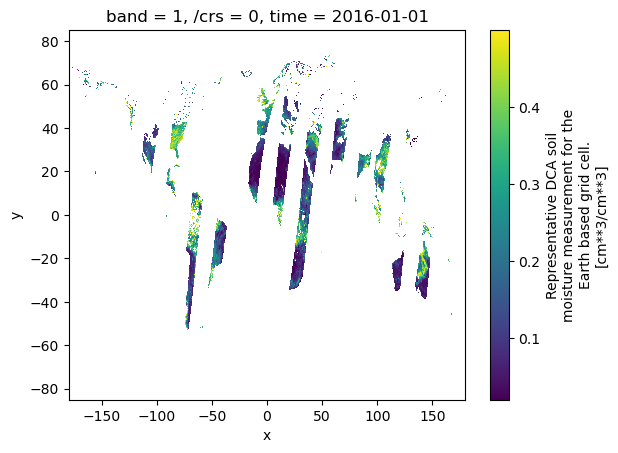

In [15]:
ds_SMAPL3_clipped = ds_SMAPL3.sel(x=slice(minx, maxx), y=slice(maxy, miny))
ds_SMAPL3.sel(time='2016-01-01').soil_moisture.plot()
# ds_SMAPL3_clipped.sel(time='2016-01-01').latitude.plot()
ds_SMAPL3_clipped
# 3.3 sec for 1 mo of data

In [16]:
ds_SMAPL3_clipped.soil_moisture

# TODO: Add dropna(how=all) somewhere to skip calculation of the ocean etc.

<xarray.DataArray 'soil_moisture' (time: 9, band: 1, y: 107, x: 113)>
dask.array<getitem, shape=(9, 1, 107, 113), dtype=float32, chunksize=(1, 1, 63, 100), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int32 1
  * x        (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
  * y        (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    /crs     int32 0
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-01-09
Attributes: (12/32)
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#coordinates:       /Soil_M...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#DIMENSION_LABELS:  {y,x}
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#grid_mapping:      /crs
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#long_name:         Represe...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#units:             cm**3/c...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#valid_max:         0.5
    ...                                                               ...
    coordinates:                                                      /Soil_M...
    DIMENSION_LABELS:                                                 {y,x}
    long_name:                                                        Represe...
    units:                                                            cm**3/c...
    valid_max:                                                        0.5
    valid_min:                                                        0.02

### Read Singer PET data

In [235]:
# Get a list of files 
# Test with 2016 Jan 1-9 data first
PET_fn_pattern = f'*_daily_pet.nc'
PET_file_paths = glob.glob(rf'{input_path}/{PET_path}/{PET_fn_pattern}')
PET_file_paths
# Load data
ds_PET = xr.open_mfdataset(PET_file_paths, combine="nested", chunks=chunks, concat_dim="time", parallel=True)
# ds_PET = xr.open_mfdataset(PET_file_paths, combine="by_coords", chunks=chunks, parallel=True)
ds_PET

<xarray.Dataset>
Dimensions:    (time: 2557, latitude: 1801, longitude: 3600)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    pet        (time, latitude, longitude) float32 dask.array<chunksize=(365, 1801, 3600), meta=np.ndarray>

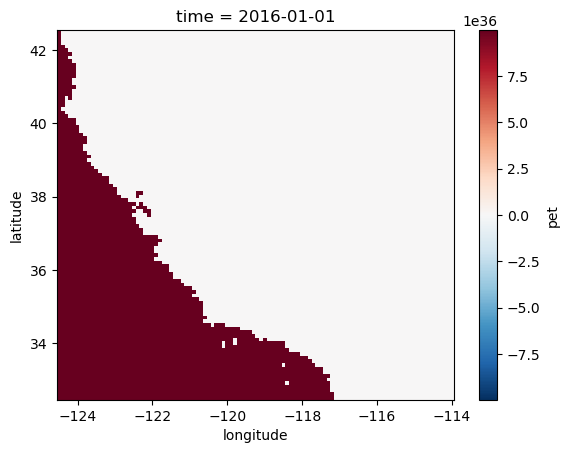

In [18]:
ds_PET_clipped = ds_PET.sel(longitude=slice(minx, maxx), latitude=slice(maxy, miny)).copy()
ds_PET_clipped.pet.sel(time='2016-01-01').plot()

## Processing data

### Get daily mean values

In [78]:
# SMAP L4
daily_P = ds_SMAPL4_clipped.precipitation_total_surface_flux.resample(time='D', skipna=True, keep_attrs=True).mean('time')

# SMAP L3
# Mask low-quality data
ds_SMAPL3_clipped['soil_moisture_pm_masked'] = ds_SMAPL3_clipped.soil_moisture_pm.where((ds_SMAPL3.retrieval_qual_flag_pm == 0) | (ds_SMAPL3.retrieval_qual_flag_pm == 8))
ds_SMAPL3_clipped['soil_moisture_am_masked'] = ds_SMAPL3_clipped.soil_moisture.where((ds_SMAPL3.retrieval_qual_flag == 0) | (ds_SMAPL3.retrieval_qual_flag == 8))

stacked_data = ds_SMAPL3_clipped[['soil_moisture_am_masked', 'soil_moisture_pm_masked']].to_array(dim='new_dim')
# daily_SM = stacked_data.mean(skipna=True, dim="new_dim")
# daily_SM.sel(time='2016-01-01').plot()
# daily_SM

ds_SMAPL3_clipped['soil_moisture_daily'] = stacked_data.mean(skipna=True, dim="new_dim")

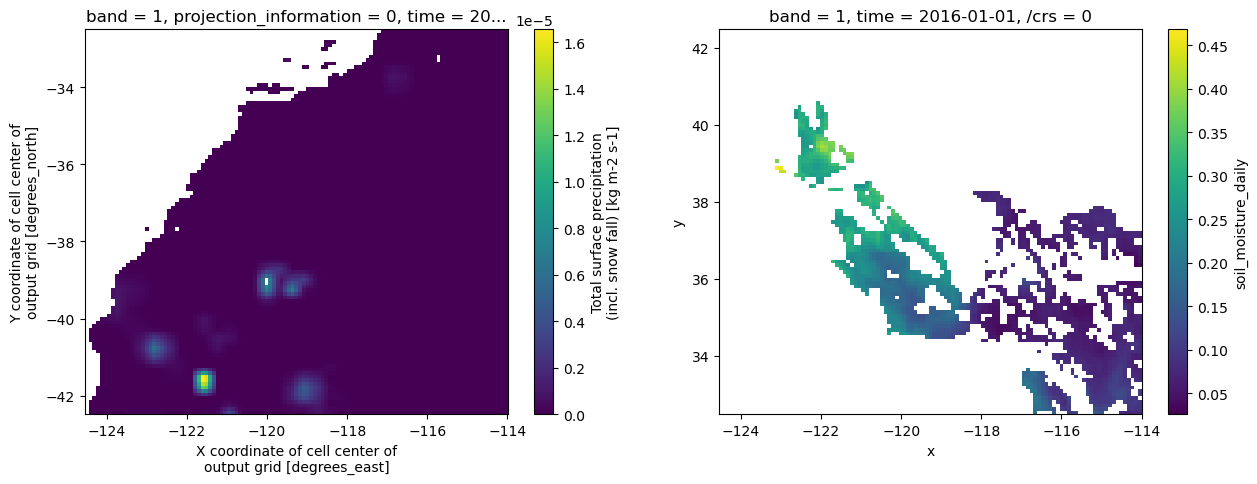

In [77]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
daily_P.sel(time='2016-01-01').plot(ax=ax1)
ds_SMAPL3_clipped.soil_moisture_daily.sel(time='2016-01-01').plot(ax=ax2)

### Calculate dS/dt

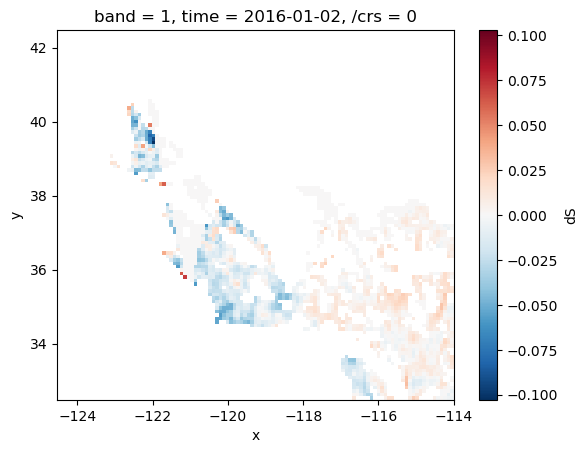

In [69]:
# Calculate dS/dt
# drop data if precipitation is less than 0.00002 & soil moisture data is null
# TODO/ISSUE: Don't know how to do this yet. 
# This is test calculation just to get things done for the latter part ... 

# Forward fill ... but then can't properly calculate dS or masks. 
ds_SMAPL3_clipped['filled_SM'] = ds_SMAPL3_clipped['soil_moisture_daily'].ffill(dim="time", limit=3)
ds_SMAPL3_clipped['dS'] = ds_SMAPL3_clipped['filled_SM'].diff(dim="time")
ds_SMAPL3_clipped['dS'].sel(time='2016-01-02').plot()

# data = [1, 2, 3, 4, np.nan, 5, 6, 7, np.nan, np.nan, 8]
# da = xr.DataArray(data, dims=('index',), coords={'index': range(len(data))})
# print(da)
# print(da.ffill(dim="index"))
# print(da.ffill(dim="index").diff(dim='index'))
# da.where(~np.isnan(da)).diff(dim="index")


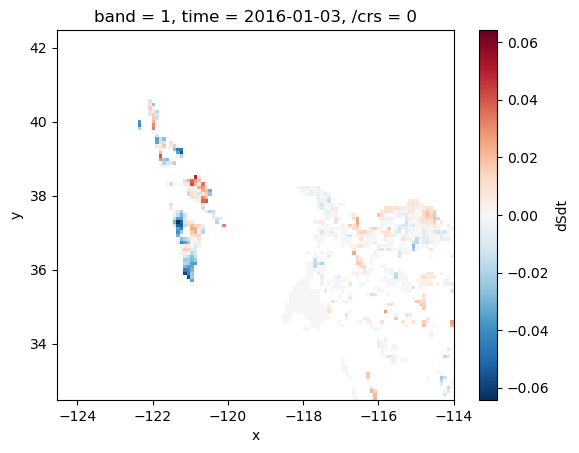

In [87]:
ds_SMAPL3_clipped['isnan_SM'] = ds_SMAPL3_clipped['soil_moisture_daily'].isnull(keep_attrs=True)
ds_SMAPL3_clipped['datagap_SM'] = ds_SMAPL3_clipped['isnan_SM'].rolling(time=3, center=True).sum()
ds_SMAPL3_clipped['dSdt'] = ds_SMAPL3_clipped['dS'] / ds_SMAPL3_clipped['datagap_SM'] 
ds_SMAPL3_clipped['dSdt'].sel(time='2016-01-03').plot()

### Mask by precipitation

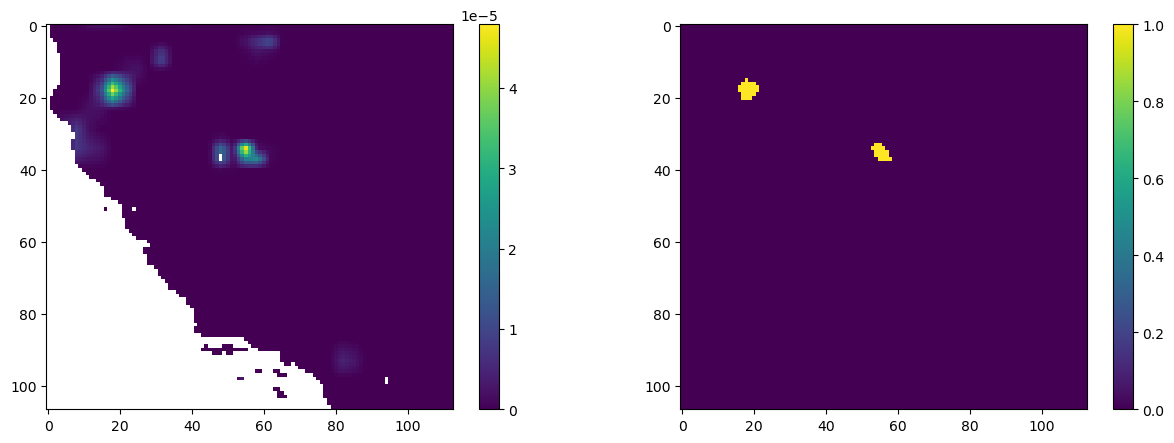

In [128]:
ds_SMAPL4_P = ds_SMAPL4_clipped.precipitation_total_surface_flux.load() # np.flip(ds_SMAPL4_clipped.precipitation_total_surface_flux.load(), axis=3)
ds_SMAPL4_P_mask = ds_SMAPL4_P > precip_thresh

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
img1 = ax1.imshow(ds_SMAPL4_P[3][0][:][:])
img2 = ax2.imshow(ds_SMAPL4_P_mask[3][0][:][:])
fig.colorbar(img1, ax=ax1)
fig.colorbar(img2, ax=ax2)
# https://geohackweek.github.io/nDarrays/09-masking/

In [140]:
# Can't mask xarray with numpy array? 
ds_SMAPL3_masked = ds_SMAPL3_clipped.where(ds_SMAPL4_P_mask == True) # something like isel? 
ds_SMAPL3_masked

<xarray.Dataset>
Dimensions:                  (time: 0, band: 1, y: 0, x: 113)
Coordinates:
  * band                     (band) int32 1
  * x                        (x) float64 -124.5 -124.4 -124.3 ... -114.1 -114.0
  * y                        (y) float64 
  * time                     (time) datetime64[ns] 
    /crs                     int32 0
    projection_information   int32 0
Data variables: (12/21)
    EASE_column_index        (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    longitude_pm             (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    retrieval_qual_flag_pm   (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    soil_moisture_pm         (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    EASE_row_index           (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    latitude                 (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    ...                       ...
    filled_SM                (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    dS                       (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    isnan_S                  (time, band, y, x) float64 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    isnan_SM                 (time, band, y, x) float64 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    datagap_SM               (time, band, y, x) float64 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    dSdt                     (time, band, y, x) float64 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
Attributes: (12/82)
    antennaRotationRate:                  14.6
    description:                          A configuration file generated auto...
    identifier:                           L3_SM_P_E_SPS
    edition:                              1.0
    publicationDate:                      2013-02-08
    title:                                Product Specification Document for ...
    ...                                   ...
    identifier_product_DOI:               doi:10.5067/4DQ54OUIJ9DL
    longName:                             SMAP Enhanced L3 Radiometer Global ...
    mission:                              SMAP
    pointOfContact:                       National Snow and Ice Data Center
    resourceProviderOrganizationName:     National Aeronautics and Space Admi...
    revisionDate:                         2021-08-31

## Fit regression b/w dS/dt & S for upper/lower PET quantile

In [275]:
ds_PET_resampled = ds_PET.sel(longitude=ds_SMAPL3_clipped['x'], latitude=ds_SMAPL3_clipped['y'], method='nearest').copy()
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# ds_PET.pet.sel(time='2016-01-01').plot(ax=ax1)
# ds_PET_resampled.sel(time='2016-01-01').pet.plot(ax=ax2)
# TODO/ISSUE: The above line takes forever. ds_PET_resampled.sel(time='2016-01-01').pet.load() takes forever as well (like 1min)

In [276]:
ds_SMAPL3_masked = ds_SMAPL3_clipped.sel(band=1)
# ds_PET_resampled.rename({'longitude':'x', 'latitude':'y'})
# print(ds_PET_resampled.pet)
# print(ds_SMAPL3_masked)
ds_PET_resampled = ds_PET_resampled.chunk({'time': len(ds_PET_resampled.time), 'x': 'auto', 'y': 'auto'})
ds_PET_resampled.pet

# TODO/ISSUE: Can NEVER rechunk at time dimension ... why? 
# Debug attempt 1: rechunk using chunk({"time": -1 or 1}) ->  no change in time dimension
# Debug attempt 2: unify_chunks() ->  no change in time dimension
# Debug attempt 3: Change options in "Read data" to "by_coord" -> no change
# Debug attempt 4: Pass dask_gufunc_kwargs = {'allow_rechunk':True} -> Error, there is no argument 'allow_rechunk'
# Use 'time': len(ds_PET_resampled.time) -> success

# dask_gufunc_kwargs = {'allow_rechunk':True}
ds_quantile = ds_PET_resampled.pet.quantile(dim="time", q=[lower_quantile_thresh, upper_quantile_thresh])
# TODO: Want to mask by ds_SMAPL3_masked['ds'] < 0

# https://stackoverflow.com/questions/73771129/rechunk-dataarray-to-calculate-90-quantile-over-over-chunked-time-dimension

In [280]:
ds_PET_quantile_upper = ds_PET_resampled.where(ds_PET_resampled.pet >= ds_quantile.sel(quantile=upper_quantile_thresh))
ds_PET_quantile_lower = ds_PET_resampled.where(ds_PET_resampled.pet <= ds_quantile.sel(quantile=lower_quantile_thresh))
print(ds_PET_quantile_upper)
print(ds_PET_quantile_lower)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ds_PET_quantile_upper.pet.sel(time='2016-01-01')
# TODO/ISSUE: When I try to load this, it says it's 8GB! WTF. Not checked 


<xarray.Dataset>
Dimensions:    (time: 2557, y: 107, x: 113)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
    latitude   (y) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    longitude  (x) float32 dask.array<chunksize=(113,), meta=np.ndarray>
  * x          (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
    /crs       int32 0
  * y          (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    quantile   float64 0.75
Data variables:
    pet        (time, y, x) float32 dask.array<chunksize=(2557, 107, 113), meta=np.ndarray>
<xarray.Dataset>
Dimensions:    (time: 2557, y: 107, x: 113)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
    latitude   (y) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    longitude  (x) float32 dask.array<chunksize=(113,), meta=np.ndarray>
  * x          (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
    /crs      

<xarray.DataArray 'pet' (y: 107, x: 113)>
dask.array<getitem, shape=(107, 113), dtype=float32, chunksize=(107, 113), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 2016-01-01
    latitude   (y) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    longitude  (x) float32 dask.array<chunksize=(113,), meta=np.ndarray>
  * x          (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
    /crs       int32 0
  * y          (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    quantile   float64 0.75

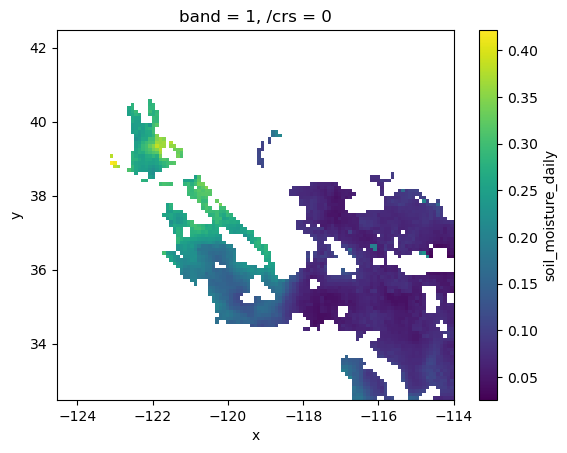

In [241]:
# ds_SMAPL3_masked
sm_min = ds_SMAPL3_masked.soil_moisture_daily.min(dim="time")

In [281]:
# Filter by upper/lower quantile of PET

# ds.polyfit('soil_moisture', 1)['polyfit_coefficients']
# m_upper = (ds['dS'].where(ds['soil_moisture'] >= pet_quantiles.sel(quantile=0.75))).polyfit('soil_moisture', 1)['polyfit_coefficients'].

# def _fit_linear(x, y):
#     mask = ~np.isnan(x) & ~np.isnan(y)
#     if np.sum(mask) < 2:
#         return np.nan
#     slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
#     return slope
# m_upper = dsa.map_blocks(_fit_linear, soil, precip, pet_upper)



# Fit dS = m*Soil moisture + b for the upper and lower PET quantiles
# m_upper = (dsoil.where(dsoil < 0) / (merged_ds['soil_moisture'] - pet_quantile.sel(quantile=0.75))).mean(dim='time')
# m_lower = (dsoil.where(dsoil < 0) / (merged_ds['soil_moisture'] - pet_quantile.sel(quantile=0.25))).mean(dim='time')

# coef_upper = np.polyfit(ds.soil_moisture.where(dSdt < 0)[:, 0, 0].values,
                            # dSdt.where(dSdt < 0)[:, 0, 0].values, 1)

# @dask.delayed
# def compute_m(ds_dS, pet_quantile, soil_moisture, upper):
#     # Fit dS = m*Soil moisture + b for a single quantile and pixel
#     if upper:
#         pet = pet_quantile.sel(quantile=0.75)
#     else:
#         pet = pet_quantile.sel(quantile=0.25)

#     ds_dS_pet = ds_dS.where((ds_pet_nearest['PET'] >= pet) & (ds_dS < 0))

#     X = da.stack([soil_moisture.values, da.ones_like(soil_moisture.values)])
#     X = da.moveaxis(X, 0, -1)
#     y = ds_dS_pet.values.flatten()

#     # Linear regression
#     XtX = da.dot(X.T, X)
#     XtX_inv = da.linalg.inv(XtX)
#     XtX_inv_Xt = da.dot(XtX_inv, X.T)
#     beta = da.dot(XtX_inv_Xt, y)

#     return beta[0]
# Compute m for upper and lower PET quantiles
# m_upper = compute_m(ds_dS_shifted_masked, pet_quantile, soil_moisture_min, True)
# m_lower = compute_m(ds_dS_shifted_masked, pet_quantile, soil_moisture_min, False)


# result = xr.apply_ufunc(my_function, ds['data_var'], input_core_dims=[['time']], output_core_dims=[['time']],
#                         output_dtypes=[ds['data_var'].dtype], dask='parallelized', output_sizes={'time': len(ds['time'])})

# https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset
